In [ ]:
# !pip install optuna

In [2]:
# !pip install catboost

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
import seaborn as sns
import sklearn.metrics as metrics
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import roc_curve, auc
import catboost
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
loan_df = pd.read_csv('data/loan_result.csv')
# log_data = pd.read_csv('data/log_Data.csv')
user_df = pd.read_csv('data/user_spec.csv')

In [3]:
loan_df.columns = ["신청서_번호","한도조회_일시","금융사_번호","상품번호","승인한도","승인금리","신청_여부(타겟)"]
loan_df.head()

,신청서_번호,한도조회_일시,금융사_번호,상품번호,승인한도,승인금리,신청_여부(타겟)
0,1748340,2022-06-07 13:05:41,7,191,42000000.0,13.6,NaN
1,1748340,2022-06-07 13:05:41,25,169,24000000.0,17.9,NaN
2,1748340,2022-06-07 13:05:41,2,7,24000000.0,18.5,NaN
3,1748340,2022-06-07 13:05:41,4,268,29000000.0,10.8,NaN
4,1748340,2022-06-07 13:05:41,11,118,5000000.0,16.4,NaN


In [4]:
loan_df['승인한도'] = loan_df['승인한도']/10000
loan_df = loan_df[["신청서_번호","금융사_번호","상품번호","승인한도","승인금리","신청_여부(타겟)"]]

In [5]:
user_df.columns = ["신청서_번호","유저_번호","유저_생년월일","유저_성별","생성일시","한도조회_당시_유저_신용점수",
                  "연소득","근로형태","입사연월","고용형태","주거소유형태","대출희망금액","대출_목적",
                  "개인회생자_여부","개인회생자_납입_완료_여부","기대출수","기대출금액"]

In [6]:
loan_df = loan_df[loan_df['승인한도'].notnull()]

### 개인회생자 처리하기

개인회생자_여부와 개인회생자_납입_완료_여부를 category로 변환

In [7]:
def 개인회생자(df):
    df.loc[(df['개인회생자_여부']==0)&
                          (df['개인회생자_납입_완료_여부']==1),'개인회생자_납입_완료_여부']=0 # 개인회생자가 아니면서 납입완료된 유저는 3명 -> 완료여부 0으로 변경

    df.loc[(df['개인회생자_여부']==0)&
                          (df['개인회생자_납입_완료_여부'].isnull()),'개인회생자_납입_완료_여부'] = 0
    df['개인회생자'] = 10 #null값인 데이터는 처리 못한 상황

    df.loc[(df['개인회생자_여부']==0)
                          &(df['개인회생자_납입_완료_여부']==0),'개인회생자'] = 0

    df.loc[(df['개인회생자_여부']==1)
                          &(df['개인회생자_납입_완료_여부']==0),'개인회생자'] = 1

    df.loc[(df['개인회생자_여부']==1)
                          &(df['개인회생자_납입_완료_여부']==1),'개인회생자'] = 2
    return df

In [8]:
user_df = 개인회생자(user_df)

### 성별 결측치 채우기

이미 기존의 데이터에 성별 및 생년월일이 존재한다면 대체

In [9]:
sex_null_list = set(user_df[(user_df['유저_번호'].isin(
    set(user_df[user_df['유저_성별'].isnull()]['유저_번호'])))&(user_df['유저_성별'].notnull())]['유저_번호'])
for i in sex_null_list:
    user_df.loc[(user_df['유저_번호']==i)&(user_df['유저_생년월일'].isnull()),
                  '유저_생년월일'] = user_df[user_df['유저_번호'] ==i]['유저_생년월일'].dropna().unique().item()
    user_df.loc[(user_df['유저_번호']==i)&(user_df['유저_성별'].isnull()),
                  '유저_성별'] = user_df[user_df['유저_번호'] ==i]['유저_성별'].dropna().unique().item()

user_train,user_test 나누기

In [11]:
user_train = user_df[user_df['신청서_번호'].isin(set(loan_df[loan_df['신청_여부(타겟)'].notnull()]['신청서_번호']))]
user_test = user_df[user_df['신청서_번호'].isin(set(loan_df[loan_df['신청_여부(타겟)'].isnull()]['신청서_번호']))]

In [12]:
print(user_train.shape)
print(user_test.shape)

(728862, 18)
(239865, 18)


In [15]:
user_train.sort_values(by = '생성일시',ascending = True,inplace = True)# 날짜순서로 sort
user_train.reset_index(drop = True,inplace = True)
user_test.sort_values(by = '생성일시',ascending = True,inplace = True)# 날짜순서로 sort
user_test.reset_index(drop = True,inplace = True)

In [16]:
train_data = user_df.dropna(how = 'any')[["유저_성별","연소득","근로형태","고용형태","주거소유형태","대출희망금액","대출_목적",
                                             "개인회생자"]]


test_data = user_test[user_test["유저_성별"].isnull()][["유저_성별","연소득","근로형태",
                                                       "고용형태","주거소유형태","대출희망금액","대출_목적","개인회생자"]]
test_data.head(3)

,유저_성별,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출_목적,개인회생자
604,NaN,30000000.0,EARNEDINCOME,정규직,전월세,15000000.0,생활비,0
960,NaN,74000000.0,EARNEDINCOME,정규직,자가,80000000.0,대환대출,0
1842,NaN,24000000.0,EARNEDINCOME,정규직,기타가족소유,15000000.0,대환대출,0


In [18]:
data = pd.concat([train_data,test_data],axis=0)
data.shape

(558947, 8)

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

le = LabelEncoder()
for col in ["고용형태","주거소유형태","대출_목적","근로형태"]:
    data[col] = le.fit_transform(data[col])

for col in ["연소득","대출희망금액"]:
    data[col] = np.log1p(data[col])   
    
train_data = data.iloc[:556936,:]    
test_data = data.iloc[556936:,:]    
    
features_train = train_data.drop("유저_성별",axis=1)
labels_train = train_data["유저_성별"]

features_test = test_data.drop("유저_성별",axis=1)
labels_test = test_data["유저_성별"]

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

X_train, X_test, y_train, y_test = train_test_split(features_train,labels_train,
                                                    random_state=0,test_size=0.2,shuffle=True,stratify=labels_train)

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter' : [100,1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

grid_search.fit(X_train, y_train)
print('test accuracy : ', grid_search.score(X_test, y_test))
print('최적의 parameters : ', grid_search.best_params_)

test accuracy :  0.6961701440011492
최적의 parameters :  {'C': 0.01, 'max_iter': 100}


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1_score_ = f1_score(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('정확도:{}, 정밀도:{}, 재현율:{}'.format(accuracy, precision, recall))
    print('f1 score:{}'.format(f1_score_))

In [22]:
lm = LogisticRegression(max_iter = 100, C=0.001)
lm.fit(X_train, y_train)
pred = lm.predict(X_test)
get_clf_eval(y_test, pred)

Confusion Matrix
[[   55 33833]
 [   92 77408]]
정확도:0.6954339785255145, 정밀도:0.6958585413651441, 재현율:0.9988129032258064
f1 score:0.8202563301031571


성별 예측진행하기

In [23]:
sex_predict = lm.predict(features_test) # 12901개의 데이터가 예측완료

In [25]:
user_test_sex_null = user_test[user_test["유저_성별"].isnull()].reset_index(drop=True)
user_test_sex_nonull = user_test[user_test["유저_성별"].notnull()].reset_index(drop=True)

user_test_sex_null["유저_성별"] = sex_predict

### 성별 결측치가 채워진 user_df_2

In [26]:
user_test = pd.concat([user_test_sex_nonull,user_test_sex_null],axis=0)

In [27]:
user_train = user_train[user_train['유저_성별'].notnull()]

In [28]:
user_test = user_test.drop(["개인회생자_여부","개인회생자_납입_완료_여부"],axis=1).reset_index(drop=True)
user_train = user_train.drop(["개인회생자_여부","개인회생자_납입_완료_여부"],axis=1).reset_index(drop=True)

In [29]:
print(user_train.shape)
print(user_test.shape)

(724130, 16)
(239865, 16)


### numeric한 데이터에 대한 이상치 처리
- 만원 단위로 낮춰서하기
- 성별, 근로형태, 고용형태, 주거소유형태 : 평균값으로 numeric 데이터 이상치 처리해주기

In [32]:
# 이상치 처리 시작
user_df_3 = pd.concat([user_train,user_test],axis = 0)
user_df_3.reset_index(drop=True,inplace = True)

### 소득분위 구간 추가하기
- https://insfiler.com/detail/rt_285_incomeq10-0001

In [33]:
for col in ["기대출금액","연소득","대출희망금액"]:
    user_df_3[col] = user_df_3[col] / 10000

In [34]:
bins = [-2, 70, 170, 2400, 3100, 3800, 4600, 5500, 6600, 8100, 12600,1000001]
#labels = ['null', '1분위', '9분위', '8등급', '7등급', '6등급', '5등급', '4등급', '3등급', '2등급', '1등급']
labels = [0,1,2,3,4,5,6,7,8,9,10]

user_df_3.loc[user_df_3['연소득'].isnull(),'연소득'] = 0
user_df_3['연소득분위'] = pd.cut(user_df_3['연소득'],bins = bins, labels = labels)


In [35]:
user_train = user_df_3[user_df_3['신청서_번호'].isin(set(loan_df[loan_df['신청_여부(타겟)'].notnull()]['신청서_번호']))]
user_test = user_df_3[user_df_3['신청서_번호'].isin(set(loan_df[loan_df['신청_여부(타겟)'].isnull()]['신청서_번호']))]
user_train.reset_index(drop = True,inplace = True)
user_test.reset_index(drop = True,inplace = True)

##### 결측치 처리하기
- 성별, 근로형태, 고용형태, 주거소유형태, 연소득분위로 하나의 그룹을 생성하고 해당 그룹의 평균값으로 채워주기

- 기대출수, 기대출금액, 신용점수등급 결측치 채우기

"유저_성별","근로형태","고용형태","주거소유형태","연소득분위"

In [38]:
def get_replace_null(full_data,data,col):
    df = full_data.copy()

    null_data = data[data[col].isnull()]
    
    nonull_test_data =data[data[col].notnull()] 
    nonull_data = df[df[col].notnull()]
    
    # 대체할 데이터가 담긴
    standard_df = nonull_data.groupby(["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"]).mean().reset_index()
    
    # null값이 대체될 데이터
    null_replace = pd.merge(null_data.drop(col,axis=1),

                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태","연소득분위",col]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"],how="inner")

    # 이상치 대체하고나서 concat해주기
    final = pd.concat([null_replace[df.columns],
               nonull_test_data],
             axis = 0)

    #final[col] = final[col].astype(int)
    
    return final.reset_index(drop=True)

"유저_성별","근로형태","고용형태","주거소유형태"

In [39]:
def get_replace_null_1(full_data,data,col):
    df = full_data.copy()

    null_data = data[data[col].isnull()]
    nonull_test_data =data[data[col].notnull()] 
    nonull_data = df[df[col].notnull()]
    
    # 대체할 데이터가 담긴
    standard_df = nonull_data.groupby(["유저_성별","근로형태","고용형태","주거소유형태"]).mean().reset_index()
    
    # null값이 대체될 데이터
    null_replace = pd.merge(null_data.drop(col,axis=1),

                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태",col]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태"],how="inner")

    # 이상치 대체하고나서 concat해주기
    final = pd.concat([null_replace[df.columns],
               nonull_test_data],
             axis = 0)

    #final[col] = final[col].astype(int)
    
    return final.reset_index(drop=True)

In [40]:
temp = user_test.copy()

In [41]:
for col in ["기대출수","기대출금액"]:
    user_test = get_replace_null(user_df_3,user_test,col)
    user_test = get_replace_null_1(user_df_3,user_test,col)
    user_test[col] = user_test[col].astype(int)


처리 안되는 유저 1명 따로 처리

In [42]:
set(temp['신청서_번호'])-set(user_test['신청서_번호'])

{1946326}

In [43]:
temp.loc[temp['신청서_번호']==1946326,'기대출금액']=temp[(temp['유저_성별']==0)&(temp['근로형태']=='PRACTITIONER')&(temp['고용형태']=='일용직')]['기대출금액'].mean()
user_test = pd.concat([user_test,temp[temp['신청서_번호']==1946326]],axis =0)

In [44]:
user_train =user_train[(user_train['기대출수'].notnull())&(user_train['기대출금액'].notnull())]

In [45]:
print(user_train.shape)
print(user_test.shape)

(552670, 17)
(239865, 17)


###### 신용점수 결측치 채우기
- 신용점수가 0점인 얘들은 원래 다 결측치
- 신용점수가 0점인 얘들은 신용점수랑 신용점수 등급 날려주기

In [46]:
# user_df_3 = pd.concat([user_train,user_test],axis = 0)
# user_df_3.reset_index(drop=True,inplace = True)

In [49]:
# 0을 결측치로 바꾸기
user_train["한도조회_당시_유저_신용점수"] = user_train["한도조회_당시_유저_신용점수"].replace(0.0, np.NaN)
user_test["한도조회_당시_유저_신용점수"] = user_test["한도조회_당시_유저_신용점수"].replace(0.0, np.NaN)


In [50]:
user_test = get_replace_null(user_df_3,user_test,"한도조회_당시_유저_신용점수")
user_test = get_replace_null_1(user_df_3,user_test,"한도조회_당시_유저_신용점수")

In [51]:
user_train = user_train[user_train['한도조회_당시_유저_신용점수'].notnull()]

In [52]:
bins = [0, 444, 514, 599, 664, 749, 804, 839, 869, 899, 1000]
labels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

user_train['신용점수등급'] = pd.cut(user_train['한도조회_당시_유저_신용점수'],bins = bins, labels = labels)
user_test['신용점수등급'] = pd.cut(user_test['한도조회_당시_유저_신용점수'],bins = bins, labels = labels)


In [53]:
user_df_3 = pd.concat([user_train,user_test],axis = 0)
user_df_3.reset_index(drop=True,inplace = True)

In [54]:
print(user_test.shape)
print(user_train.shape)

(239865, 18)
(534883, 18)


##### 개인회생자 결측치 처리하기
- 9등급 이하인 경우에는 0으로 할당하기

In [58]:
user_test['개인회생자'].value_counts()

0     236649
1       1851
10      1108
2        257
Name: 개인회생자, dtype: int64

In [59]:
user_df_3_ = user_test.copy()

In [60]:
user_df_3_null = user_df_3_[(user_df_3_["개인회생자"] == 10) & (user_df_3_["신용점수등급"] == 10)]
user_df_3_nonull1 = user_df_3_[(user_df_3_["개인회생자"] == 10) & (user_df_3_["신용점수등급"] != 10)]
user_df_3_nonull2 = user_df_3_[(user_df_3_["개인회생자"] != 10)]

##### 신용점수가 9등급이상인 것들 해결하기

In [61]:
user_df_3_nonull1["개인회생자"] = 0

##### 신용점수가 10등급인 것들 해결하기
- 신용점수가 150미만인 것들은 1로 할당
- 신용점수가 150이상이면 1로 할당

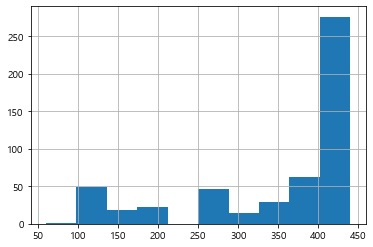

In [62]:
user_df_3[(user_df_3["신용점수등급"] == 10) &
                  (user_df_3["개인회생자"] == 0)]["한도조회_당시_유저_신용점수"].hist()

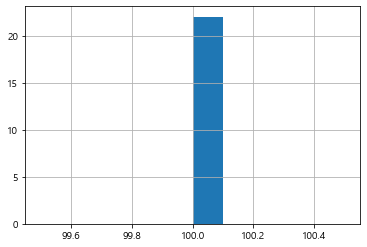

In [63]:
user_df_3[(user_df_3["신용점수등급"] == 10) &
                  (user_df_3["개인회생자"] == 2)]["한도조회_당시_유저_신용점수"].hist()

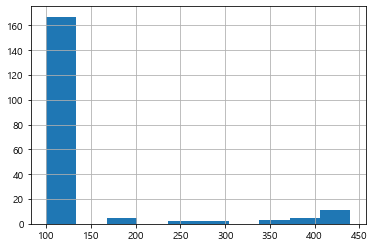

In [64]:
user_df_3[(user_df_3["신용점수등급"] == 10) &
                  (user_df_3["개인회생자"] == 1)]["한도조회_당시_유저_신용점수"].hist()

In [65]:
user_df_3_null1 = user_df_3_null[user_df_3_null["한도조회_당시_유저_신용점수"] < 150]
user_df_3_null2 = user_df_3_null[user_df_3_null["한도조회_당시_유저_신용점수"] >= 150]

user_df_3_null1["개인회생자"] = 1
user_df_3_null2["개인회생자"] = 0

In [66]:
user_train = user_train[user_train['개인회생자']!=10]

In [67]:
user_test = pd.concat([user_df_3_nonull2,user_df_3_nonull1,user_df_3_null1,user_df_3_null2],axis=0)

In [68]:
user_df_3 = pd.concat([user_train,user_test],axis = 0)
user_df_3.reset_index(drop=True,inplace = True)

##### 기대출수 먼저 이상치 잡기
##### 대출희망금액 먼저 이상치 잡기

In [69]:
def find_outlier_z(data):
    
    threshold = 3
    
    mean = np.mean(data)
    std = np.std(data)
    
    z_score = [(y-mean) / std for y in data]
    
    masks = np.where(np.abs(z_score) >= threshold)
    
    #print(mean+threshold*std)
    #print(mean-threshold*std)
    return masks[0]

In [70]:
def no_outlier_z(data):
    
    threshold = 3
    
    mean = np.mean(data)
    std = np.std(data)
    
    z_score = [(y-mean) / std for y in data]
    
    masks = np.where(np.abs(z_score) < threshold)
    
    #print(mean+threshold*std)
    #print(mean-threshold*std)
    return masks[0]

결측을 채울 기준이 되는 dataframe
- 기준이 되는 dataframe : standard_df

In [71]:
def iqr_func(x):
    q3, q1 = np.percentile(x, [75, 25])
    iqr = q3 - q1
    final = q3 + 1.5*iqr
    return int(final)

In [72]:
def get_replace_outlier(data,col):
    # col에 해당하는 이상치 대체하기
    # data : 이상치 대체할 데이터프레임
    
    df = data.copy()
    
    # 이상치 대체의 기준 dataframe
    standard_df = df[df[col].notnull()].groupby(["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"]
                               ).agg({col: iqr_func}).reset_index()
    
    # 이상치의 index
    outlier_index = find_outlier_z(df[col])
    
    # 이상치 아닌 것 index
    nooutlier_index = no_outlier_z(df[col])
    
    # 이상치에 속하는 데이터
    outlier_data = df.loc[outlier_index,:]
    
    # 이상치가 아닌 것에 속하는 데이터
    nooutlier_data = df.loc[nooutlier_index,:]
    
    # 이상치가 대체된 데이터프레임
    
    outlier_replace = pd.merge(outlier_data.drop(col,axis=1),
              
              standard_df[["유저_성별","근로형태","고용형태","주거소유형태","연소득분위",col]]
         
         ,on=["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"],how="inner")

    
    # 이상치 대체하고나서 concat해주기
    final = pd.concat([outlier_replace[df.columns],
           nooutlier_data,
          df[df[col].isnull()]],
         axis = 0)
    
    
    return final.reset_index(drop=True)

##### user_df_4 : column의 이상치가 처리된 dataframe

In [73]:
user_df_4 = get_replace_outlier(user_df_3,"기대출수")

user_df_4 = get_replace_outlier(user_df_4,"기대출금액")

user_df_4 = get_replace_outlier(user_df_4,"대출희망금액")

user_df_4 = get_replace_outlier(user_df_4,"연소득")

##### user_df_5 : 연소득 0원 이상치가 처리된 dataframe

In [74]:
user_df_5 = user_df_4.copy()
user_df_5[user_df_5["대출희망금액"] == 0]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,주거소유형태,대출희망금액,대출_목적,기대출수,기대출금액,개인회생자,연소득분위,신용점수등급
52,1341046,732757,1982.0,1.0,2022-05-06 10:29:46,650.0,36250.0,EARNEDINCOME,200801.0,정규직,전월세,0.0,생활비,4.0,1800.0,0,10,7
558,805227,26899,1960.0,1.0,2022-05-25 01:48:38,600.0,101075.0,OTHERINCOME,NaN,기타,자가,0.0,사업자금,8.0,9700.0,0,10,7
1212,1336031,781341,1989.0,1.0,2022-06-21 21:09:13,650.0,112987.0,EARNEDINCOME,20210801.0,계약직,기타가족소유,0.0,대환대출,5.0,10200.0,0,10,7
1229,982323,167746,1981.0,1.0,2022-06-24 07:51:55,600.0,52500.0,FREELANCER,20130624.0,기타,전월세,0.0,생활비,6.0,3400.0,0,10,7
4492,285970,776496,1980.0,1.0,2022-05-15 20:10:59,760.0,11000.0,EARNEDINCOME,201112.0,정규직,전월세,0.0,생활비,7.0,43500.0,0,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478967,643845,458501,1995.0,1.0,2022-06-10 21:46:37,750.0,800.0,FREELANCER,20210101.0,기타,전월세,0.0,생활비,3.0,2581.0,0,2,5
478968,515047,458501,1995.0,1.0,2022-06-15 14:48:17,750.0,800.0,FREELANCER,20210101.0,기타,전월세,0.0,생활비,3.0,2581.0,0,2,5
478971,1928816,458501,1995.0,1.0,2022-06-21 06:08:21,750.0,800.0,FREELANCER,20210101.0,기타,전월세,0.0,생활비,3.0,2581.0,0,2,5
478972,345511,458501,1995.0,1.0,2022-06-22 15:48:48,750.0,800.0,FREELANCER,20210101.0,기타,전월세,0.0,생활비,3.0,2581.0,0,2,5


In [75]:
user_train = user_df_5[user_df_5['신청서_번호'].isin(set(loan_df[loan_df['신청_여부(타겟)'].notnull()]['신청서_번호']))]
user_test = user_df_5[user_df_5['신청서_번호'].isin(set(loan_df[loan_df['신청_여부(타겟)'].isnull()]['신청서_번호']))]
user_train.reset_index(drop = True,inplace = True)
user_test.reset_index(drop = True,inplace = True)

#### 연소득 0원 데이터 처리하기
- OTHERINCOME 기타소득을 제외하곤 연소득 0원을 평균으로 대체하기

In [76]:
user_df_5.shape

(479473, 18)

In [77]:
drop_list = set(user_train[(user_train['연소득']==0)&(user_train['근로형태']!='OTHERINCOME')]['신청서_번호'])
user_train.drop(user_train[user_train['신청서_번호'].isin(drop_list)].index,inplace = True)

- 근로형태에 따라서 하나씩 평균값 대입

In [78]:
df_lst = []

for work_type in ['FREELANCER', 'PRIVATEBUSINESS', 'EARNEDINCOME', 'EARNEDINCOME2',
       'PRACTITIONER']:
    
    # 연소득 0원 채워야하는 데이터
    replaced = user_test[(user_test["연소득"] == 0) & (user_test["근로형태"] == work_type)]

    # 연소득 0원이 아닌 데이터
    no_replace = user_test[(user_test["연소득"] != 0) & (user_test["근로형태"] == work_type)]
    
    standard_df = user_df_5.groupby(["유저_성별","근로형태","고용형태","주거소유형태"]).mean().reset_index()
   
    # 0값이 처리된 데이터
    zero_replace = pd.merge(replaced.drop("연소득",axis=1),

                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태","연소득"]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태"],how="inner")

    zero_replace = zero_replace[user_test.columns] # 0값이 처리된 데이터
    zero_replace["연소득"] = zero_replace["연소득"].astype(int)
    
    print(work_type,"전처리 끝")
    
    df_lst.append(zero_replace)
    df_lst.append(no_replace)
    
df_lst.append(user_test[user_test["근로형태"] == "OTHERINCOME"])

FREELANCER 전처리 끝
PRIVATEBUSINESS 전처리 끝
EARNEDINCOME 전처리 끝
EARNEDINCOME2 전처리 끝
PRACTITIONER 전처리 끝


#### 대출희망금액 0원 전처리
- "유저_성별","근로형태","고용형태","주거소유형태","연소득분위" 기반 평균으로 대체
- 그래도 0이면?
- "유저_성별","근로형태","고용형태","주거소유형태" 기반 평균으로 대체

In [79]:
user_test = pd.concat(df_lst,axis=0).reset_index(drop=True)

In [80]:
user_df_5 = pd.concat([user_train,user_test],axis = 0)
user_df_5.reset_index(drop=True,inplace = True)

In [81]:
# 대출희망금액 0원 채워야하는 데이터
replaced = user_test[(user_test["대출희망금액"] == 0)]

# 대출희망금액 0원이 아닌 데이터
no_replace = user_test[(user_test["대출희망금액"] != 0)]
    
standard_df = user_df_5.groupby(["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"]).mean().reset_index()

In [82]:
# 0값이 처리된 데이터
zero_replace = pd.merge(replaced.drop("대출희망금액",axis=1),
                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태","연소득분위","대출희망금액"]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태","연소득분위"],how="inner")

zero_replace = zero_replace[user_test.columns] # 0값이 처리된 데이터
zero_replace["대출희망금액"] = zero_replace["대출희망금액"].astype(int)

In [83]:
user_test = pd.concat([zero_replace,no_replace],axis=0).reset_index(drop=True)
user_train = user_train[(user_train["대출희망금액"] != 0)]

"유저_성별","근로형태","고용형태","주거소유형태" 기반 평균으로 대체

In [84]:
# 대출희망금액 0원 채워야하는 데이터
replaced = user_test[(user_test["대출희망금액"] == 0)]

# 대출희망금액 0원이 아닌 데이터
no_replace = user_test[(user_test["대출희망금액"] != 0)]
    
standard_df = user_df_5.groupby(["유저_성별","근로형태","고용형태","주거소유형태"]).mean().reset_index()

# 0값이 처리된 데이터
zero_replace = pd.merge(replaced.drop("대출희망금액",axis=1),
                  standard_df[["유저_성별","근로형태","고용형태","주거소유형태","대출희망금액"]]

             ,on=["유저_성별","근로형태","고용형태","주거소유형태"],how="inner")

zero_replace = zero_replace[user_test.columns] # 0값이 처리된 데이터
zero_replace["대출희망금액"] = zero_replace["대출희망금액"].astype(int)

user_test = pd.concat([zero_replace,no_replace],axis=0).reset_index(drop=True)

In [85]:
user_train.reset_index(drop=True,inplace = True)
user_test.reset_index(drop=True,inplace = True)

In [86]:
user_df_5 = pd.concat([user_train,user_test],axis = 0)
user_df_5.reset_index(drop=True,inplace = True)

############### 이상치 처리 끝 #####################

## 생년월일 이상치 처리

In [88]:
user_test = get_replace_null_1(user_df_5,user_test,'유저_생년월일')
user_test['유저_생년월일'] = user_test['유저_생년월일'].astype(int)

In [89]:
user_df_5 = pd.concat([user_train,user_test],axis = 0)
user_df_5.reset_index(drop=True,inplace = True)

## 입사연월 이상치 및 결측치 처리

In [91]:
user_df_5_1 = user_df_5.copy()

In [92]:
#소수만 입사연월있음 -> 이상치로 보고 모두 입사연월 제거
user_df_5.loc[user_df_5['근로형태']=='OTHERINCOME','입사연월'] ='nan'

In [93]:
user_df_5[user_df_5['입사연월'].isnull()]['근로형태'].value_counts()

PRIVATEBUSINESS    2
EARNEDINCOME       1
Name: 근로형태, dtype: int64

In [94]:
#입사연월은 평균값이 안됨 -> 최빈값으로 대체
user_list = list(user_df_5[(user_df_5['입사연월'].isnull())&(user_df_5['근로형태']=='EARNEDINCOME')]['유저_번호'].index)+list(user_df_5[(user_df_5['입사연월'].isnull())&(user_df_5['근로형태']=='PRIVATEBUSINESS')]['유저_번호'].index)
for i in user_list:
    user_df_5.iloc[i,8] = user_df_5[(user_df_5['근로형태']==user_df_5.iloc[i,7])&(user_df_5['유저_생년월일']==user_df_5.iloc[i,2])&(user_df_5['유저_성별']==user_df_5.iloc[i,3])]['입사연월'].mode()[0]

In [95]:
#생성일시 datetime으로 변경
user_df_5['생성일시_연월'] = user_df_5['생성일시'].str[:7]
user_df_5['생성일시_연월'] = user_df_5['생성일시_연월'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
user_df_5['생성일시_연월'] = pd.to_datetime(user_df_5['생성일시_연월'],format = '%Y%m')

In [96]:
#입사연월 datetime으로 변경
user_df_5['입사연월_연월'] = user_df_5['입사연월'].astype(str).str[:6]
user_df_5.loc[user_df_5['입사연월_연월']=='nan','입사연월_연월'] = '202301'# nan값인 데이터들 처리
user_df_5.loc[user_df_5['입사연월'].isnull(),'입사연월'] = '202301'
user_df_5['입사연월_연월'] = pd.to_datetime(user_df_5['입사연월_연월'],format = '%Y%m')

유저_생년월일보다 입사연월_연월이 더 빠른경우->   
 [유저_생년월일,유저_성별,근로형태,고용형태]를 기준으로 최빈값 넣기

In [97]:
user_df_5['유저_생년월일'] = pd.to_datetime(user_df_5['유저_생년월일'],format = '%Y') #유저 생년월일 datetime으로 변경

In [98]:
temp_list =set(user_df_5[user_df_5['유저_생년월일']>user_df_5['입사연월_연월']]['신청서_번호'])#유저 생년월일이 입사연월보다 빠른 유저 리스트
temp = list(user_df_5[user_df_5['신청서_번호'].isin(temp_list)].index)
for i in temp:
    user_df_5.iloc[i,-1] = user_df_5[(user_df_5['유저_생년월일']==user_df_5.iloc[i,2])
                                              &(user_df_5['유저_성별']==user_df_5.iloc[i,3])
                                              &(user_df_5['근로형태']==user_df_5.iloc[i,7])
                                              &(user_df_5['고용형태']==user_df_5.iloc[i,9])]['입사연월_연월'].mode()[0]

In [99]:
from datetime import datetime
def diff_month(x): # 입사개월 계산 함수
    return (x[0].year - x[1].year) * 12 + x[0].month - x[1].month + 1
def diff_year(x): # 년차 계산 함수
    return x[0].year - x[1].year

In [101]:
user_df_5['입사개월'] = user_df_5[['생성일시_연월', '입사연월_연월']].apply(diff_month,axis=1)
user_df_5['입사개월'] = user_df_5['입사개월'].astype(int)
user_df_5.loc[user_df_5['입사개월']<1,'입사개월'] = 0# 입사연월이 없는 otherincome 유저들은 0으로 mapping


In [102]:
user_df_5['입사나이'] = user_df_5[['입사연월_연월','유저_생년월일']].apply(diff_year,axis =1)#입사나이
user_df_5[user_df_5['입사나이']<15]['근로형태'].value_counts()


PRIVATEBUSINESS    75
EARNEDINCOME       57
FREELANCER         14
PRACTITIONER        6
EARNEDINCOME2       6
Name: 근로형태, dtype: int64

In [103]:
user_df_5.columns

Index(['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득',
       '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '기대출수', '기대출금액',
       '개인회생자', '연소득분위', '신용점수등급', '생성일시_연월', '입사연월_연월', '입사개월', '입사나이'],
      dtype='object')

In [104]:
# 법적 근무나이인 만 15세 이하인 유저들 중 사업과 프리랜서를 제외한 122명은 최빈값으로 처리
user_list = list(user_df_5[(user_df_5['입사나이']<15)&(user_df_5['근로형태']!='PRIVATEBUSINESS')&(user_df_5['근로형태']!='FREELANCER')]['신청서_번호'].index)
for i in user_list:
    user_df_5.iloc[i,-3] = user_df_5[(user_df_5['유저_생년월일']==user_df_5.iloc[i,2])
                                              &(user_df_5['유저_성별']==user_df_5.iloc[i,3])
                                              &(user_df_5['근로형태']==user_df_5.iloc[i,7])
                                              &(user_df_5['고용형태']==user_df_5.iloc[i,9])]['입사연월_연월'].mode()[0]

In [105]:
#입사연월 변경으로 인한 입사개월 다시 계산 
user_df_5['입사개월'] = user_df_5[['생성일시_연월', '입사연월_연월']].apply(diff_month,axis=1)
user_df_5['입사개월'] = user_df_5['입사개월'].astype(int)
user_df_5.loc[user_df_5['입사개월']<1,'입사개월'] = 0# 입사연월이 없는 otherincome 유저들은 0으로 mapping

In [106]:
user_df_5['나이'] = user_df_5[['생성일시_연월','유저_생년월일']].apply(diff_year,axis =1)#나이
user_df_5['나이'] = user_df_5['나이'].astype(int)

In [108]:
user_train = user_df_5[user_df_5['신청서_번호'].isin(set(loan_df[loan_df['신청_여부(타겟)'].notnull()]['신청서_번호']))]
user_test = user_df_5[user_df_5['신청서_번호'].isin(set(loan_df[loan_df['신청_여부(타겟)'].isnull()]['신청서_번호']))]
user_train.reset_index(drop = True,inplace = True)
user_test.reset_index(drop = True,inplace = True)

In [109]:
print(user_train.shape)
print(user_test.shape)

(238826, 23)
(239865, 23)


## 병합용 데이터 처리

In [110]:
temp = user_df_5[['신청서_번호', '유저_번호', '유저_성별','근로형태', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '기대출수', '기대출금액',
       '개인회생자', '신용점수등급', '연소득분위', '입사개월', '나이']]

In [111]:
temp['기대출금액'] = round(temp['기대출금액'],-3)
temp['대출희망금액'] = round(temp['대출희망금액'],-3)

In [112]:
loan_df_train = loan_df[loan_df['신청_여부(타겟)'].notnull()]

In [114]:
df= pd.merge(temp,loan_df,how ='inner',on = '신청서_번호')
# clustering_df = pd.merge(temp,loan_df_train, how='left', left_on='신청서_번호', right_on='신청서_번호')

제출파일형식과 맞게 test 데이터 변형

In [115]:
df1 = pd.merge(temp,loan_df,how ='inner',on = '신청서_번호')

In [116]:
result_set =  pd.read_csv('데이터분석분야_퓨처스부문_평가데이터.csv')
result_set.columns = ['신청서_번호','상품번호','신청_여부(타겟)']

In [119]:
temp_result = df1[df1['신청_여부(타겟)'].isnull()]
temp_result=temp_result.drop_duplicates(['신청서_번호','상품번호'], keep=False)
temp_result = temp_result.sort_values(by = '신청서_번호')
temp_result.reset_index(drop= True,inplace =True)

In [120]:
tt = pd.merge(result_set,temp_result,on = ['신청서_번호','상품번호'])

In [122]:
tt.drop(columns = ['신청_여부(타겟)_x','유저_번호'],axis =1,inplace=True)
tt.rename(columns ={'신청_여부(타겟)_y':'신청_여부(타겟)'},inplace = True)

In [125]:
# df.to_csv('prediction_df_final.csv')

상품 번호 드랍한 버전

In [307]:
df = df[['유저_성별', '근로형태', '고용형태', '주거소유형태', '대출희망금액', '대출_목적',
       '기대출수', '기대출금액', '개인회생자', '신용점수등급', '연소득분위', '입사개월', '나이', '금융사_번호',
        '승인한도', '승인금리', '신청_여부(타겟)']]

In [ ]:
train = df[df['신청_여부(타겟)'].notnull()]
train.reset_index(drop= True,inplace =True)
test=tt[['유저_성별', '근로형태', '고용형태', '주거소유형태', '대출희망금액', '대출_목적',
       '기대출수', '기대출금액', '개인회생자', '신용점수등급', '연소득분위', '입사개월', '나이', '금융사_번호',
        '승인한도', '승인금리', '신청_여부(타겟)']]
test.reset_index(drop= True,inplace =True)

In [213]:
train_cat_col = train[['근로형태','고용형태','주거소유형태','대출_목적','신용점수등급','연소득분위','금융사_번호','신청_여부(타겟)']]
train_feature = train.drop(list(train_cat_col.columns),axis=1)
train_label = train["신청_여부(타겟)"]
test_cat_col = test[['근로형태','고용형태','주거소유형태','대출_목적','신용점수등급','연소득분위','금융사_번호','신청_여부(타겟)']]
test_feature = test.drop(list(test_cat_col.columns),axis=1)
test_label = test["신청_여부(타겟)"]

In [214]:
df_col = train_feature.columns

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalization 최소값 0 / 최대값 1
scaler = StandardScaler()

train_feature = scaler.fit_transform(train_feature)
test_feature = scaler.transform(test_feature)

train_feature = pd.DataFrame(train_feature,columns = df_col)
test_feature = pd.DataFrame(test_feature,columns = df_col)

In [ ]:
train= pd.concat([train_feature,train_cat_col],axis =1)
test = pd.concat([test_feature,test_cat_col],axis =1)

In [ ]:
features = list(train.columns)
features.remove('신청_여부(타겟)')
cat_features = ['근로형태','고용형태','주거소유형태','대출_목적','신용점수등급','연소득분위','금융사_번호']

In [215]:
# seed = 42
# n_fold = 10
# n_class = 2

target = '신청_여부(타겟)'
train_X = train[features]
train_Y = train[target]


Modeling

In [154]:
def objective(trial):
    score = []
    kf = StratifiedKFold(n_splits = 6, random_state = 42 , shuffle = True)
    for train_fold, test_fold in tqdm_notebook(kf.split(train_X, train_Y), desc = 'k_fold'):
        X_train, X_test, y_train, y_test = train_X.iloc[train_fold], train_X.iloc[test_fold], train_Y[train_fold], train_Y[test_fold] 
        
        # Parameter 범위는 처음에는 넓게, 이후 조금씩 줄여나가는 것을 추천 # 
        params = {
            'iterations':trial.suggest_int("iterations", 100, 300),
            "max_ctr_complexity":2,
            'learning_rate' : trial.suggest_uniform('learning_rate',0.1, 1),
            'depth': trial.suggest_int('depth',1, 15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1,100),
            'subsample': trial.suggest_uniform('subsample',0.3,1),
            'random_strength': trial.suggest_uniform('random_strength',10,100),
            'od_wait':trial.suggest_int('od_wait', 10, 150),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 1, 100),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0., 1.0),
            'random_state' : 0,
            'verbose' : 0,
        }
    
            
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test,y_test)],
                  early_stopping_rounds=35,cat_features=cat_features,
                  verbose=100)
        pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test, pred_proba)
        auc_score = auc(fpr, tpr)
        score.append(auc_score)

    return np.mean(score)

In [155]:
sampler = TPESampler(seed = 42)

optim = optuna.create_study(
    direction="maximize",sampler=sampler)

optim.optimize(objective, n_trials=15) 
print("Best auc:", optim.best_value)

[I 2022-10-12 02:12:01,406] A new study created in memory with name: no-name-fbd80e34-70ec-43de-aebd-7ff3535aba06


0:	learn: 0.2162296	test: 0.2162241	test1: 0.2162369	best: 0.2162369 (0)	total: 965ms	remaining: 2m 47s
100:	learn: 0.1871385	test: 0.1869881	test1: 0.1867221	best: 0.1867221 (100)	total: 39.4s	remaining: 28.8s
174:	learn: 0.1834125	test: 0.1832237	test1: 0.1830742	best: 0.1830742 (174)	total: 1m 4s	remaining: 0us

bestTest = 0.1830742079
bestIteration = 174

0:	learn: 0.2162250	test: 0.2162184	test1: 0.2162698	best: 0.2162698 (0)	total: 672ms	remaining: 1m 56s
100:	learn: 0.1917928	test: 0.1914647	test1: 0.1915967	best: 0.1915967 (100)	total: 37s	remaining: 27.1s
174:	learn: 0.1896444	test: 0.1893215	test1: 0.1895565	best: 0.1895565 (174)	total: 1m 3s	remaining: 0us

bestTest = 0.1895564782
bestIteration = 174

0:	learn: 0.2290338	test: 0.2290338	test1: 0.2290309	best: 0.2290309 (0)	total: 459ms	remaining: 1m 19s
100:	learn: 0.1866797	test: 0.1865246	test1: 0.1864736	best: 0.1864736 (100)	total: 38.4s	remaining: 28.2s
174:	learn: 0.1832778	test: 0.1830617	test1: 0.1827729	best: 0.1827

[I 2022-10-12 02:19:53,554] Trial 0 finished with value: 0.8277099468360869 and parameters: {'iterations': 175, 'learning_rate': 0.9556428757689246, 'depth': 11, 'min_data_in_leaf': 18, 'reg_lambda': 16.445845403801215, 'subsample': 0.40919616423534183, 'random_strength': 15.227525095137953, 'od_wait': 132, 'leaf_estimation_iterations': 10, 'bagging_temperature': 26.070247583707673, 'colsample_bylevel': 0.020584494295802447}. Best is trial 0 with value: 0.8277099468360869.


0:	learn: 0.2320024	test: 0.2320024	test1: 0.2319815	best: 0.2319815 (0)	total: 997ms	remaining: 4m 52s
100:	learn: 0.1741453	test: 0.1739638	test1: 0.1745617	best: 0.1745617 (100)	total: 1m 11s	remaining: 2m 15s
200:	learn: 0.1713719	test: 0.1712102	test1: 0.1720550	best: 0.1720550 (200)	total: 2m 18s	remaining: 1m 4s
293:	learn: 0.1699089	test: 0.1697526	test1: 0.1707015	best: 0.1707015 (293)	total: 3m 19s	remaining: 0us

bestTest = 0.1707015182
bestIteration = 293

0:	learn: 0.2320203	test: 0.2320203	test1: 0.2319119	best: 0.2319119 (0)	total: 975ms	remaining: 4m 45s
100:	learn: 0.1732429	test: 0.1731102	test1: 0.1736639	best: 0.1736639 (100)	total: 1m 8s	remaining: 2m 11s
200:	learn: 0.1705626	test: 0.1704056	test1: 0.1713427	best: 0.1713427 (200)	total: 2m 13s	remaining: 1m 1s
293:	learn: 0.1694258	test: 0.1692754	test1: 0.1705075	best: 0.1705075 (293)	total: 3m 16s	remaining: 0us

bestTest = 0.1705075394
bestIteration = 293

0:	learn: 0.2340965	test: 0.2340965	test1: 0.2340940	be

[I 2022-10-12 02:41:31,719] Trial 1 finished with value: 0.8672758024140542 and parameters: {'iterations': 294, 'learning_rate': 0.8491983767203796, 'depth': 4, 'min_data_in_leaf': 6, 'reg_lambda': 19.15704647548995, 'subsample': 0.5129695700716763, 'random_strength': 57.228078846901404, 'od_wait': 70, 'leaf_estimation_iterations': 5, 'bagging_temperature': 16.73808578875213, 'colsample_bylevel': 0.13949386065204183}. Best is trial 1 with value: 0.8672758024140542.


0:	learn: 0.3389522	test: 0.3389522	test1: 0.3389472	best: 0.3389472 (0)	total: 580ms	remaining: 1m 31s
100:	learn: 0.1784742	test: 0.1784033	test1: 0.1785575	best: 0.1785575 (100)	total: 1m	remaining: 34s
157:	learn: 0.1735373	test: 0.1734165	test1: 0.1737921	best: 0.1737921 (157)	total: 1m 39s	remaining: 0us

bestTest = 0.173792103
bestIteration = 157

0:	learn: 0.3389436	test: 0.3389436	test1: 0.3390002	best: 0.3390002 (0)	total: 599ms	remaining: 1m 34s
100:	learn: 0.1767641	test: 0.1766460	test1: 0.1770759	best: 0.1770759 (100)	total: 1m 3s	remaining: 36s
157:	learn: 0.1730495	test: 0.1729610	test1: 0.1736326	best: 0.1736326 (157)	total: 1m 44s	remaining: 0us

bestTest = 0.1736326077
bestIteration = 157

0:	learn: 0.3398143	test: 0.3398143	test1: 0.3398130	best: 0.3398130 (0)	total: 428ms	remaining: 1m 7s
100:	learn: 0.1772079	test: 0.1771397	test1: 0.1768087	best: 0.1768087 (100)	total: 1m 6s	remaining: 37.4s
157:	learn: 0.1734857	test: 0.1734626	test1: 0.1731848	best: 0.1731848 (

[I 2022-10-12 02:53:26,472] Trial 2 finished with value: 0.8569562039201096 and parameters: {'iterations': 158, 'learning_rate': 0.4297256589643226, 'depth': 7, 'min_data_in_leaf': 24, 'reg_lambda': 20.767704433677615, 'subsample': 0.6599641068895281, 'random_strength': 63.31731119758382, 'od_wait': 16, 'leaf_estimation_iterations': 10, 'bagging_temperature': 2.1930485556643684, 'colsample_bylevel': 0.06505159298527952}. Best is trial 1 with value: 0.8672758024140542.


0:	learn: 0.2259474	test: 0.2259467	test1: 0.2260670	best: 0.2260670 (0)	total: 2.72s	remaining: 13m 6s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1710813834
bestIteration = 44

Shrink model to first 45 iterations.
0:	learn: 0.2286989	test: 0.2286994	test1: 0.2287096	best: 0.2287096 (0)	total: 1.85s	remaining: 8m 55s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1711409749
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 0.2279407	test: 0.2279378	test1: 0.2278430	best: 0.2278430 (0)	total: 2.37s	remaining: 11m 26s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1708493719
bestIteration = 40

Shrink model to first 41 iterations.
0:	learn: 0.2279242	test: 0.2279222	test1: 0.2279410	best: 0.2279410 (0)	total: 2.44s	remaining: 11m 44s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1714627377
bestIteration = 40

Shrink model to first 41 iterations.
0:	learn: 0.2279147	test: 0.2279133	te

[I 2022-10-12 03:42:08,109] Trial 3 finished with value: 0.8694395787984531 and parameters: {'iterations': 290, 'learning_rate': 0.9690688297671034, 'depth': 13, 'min_data_in_leaf': 10, 'reg_lambda': 10.669539286632004, 'subsample': 0.7789631185585097, 'random_strength': 49.61372443656412, 'od_wait': 27, 'leaf_estimation_iterations': 8, 'bagging_temperature': 1.1715937392307056, 'colsample_bylevel': 0.9093204020787821}. Best is trial 3 with value: 0.8694395787984531.


0:	learn: 0.2471720	test: 0.2471697	test1: 0.2472816	best: 0.2472816 (0)	total: 2.6s	remaining: 6m 32s
100:	learn: 0.1703566	test: 0.1701680	test1: 0.1706412	best: 0.1706412 (100)	total: 2m 58s	remaining: 1m 29s
151:	learn: 0.1686560	test: 0.1684799	test1: 0.1693561	best: 0.1693561 (151)	total: 4m 39s	remaining: 0us

bestTest = 0.1693560933
bestIteration = 151

0:	learn: 0.2472216	test: 0.2472206	test1: 0.2471064	best: 0.2471064 (0)	total: 2.65s	remaining: 6m 40s
100:	learn: 0.1700527	test: 0.1698961	test1: 0.1707112	best: 0.1707112 (100)	total: 3m 5s	remaining: 1m 33s
151:	learn: 0.1683481	test: 0.1681847	test1: 0.1693894	best: 0.1693894 (151)	total: 4m 39s	remaining: 0us

bestTest = 0.1693893519
bestIteration = 151

0:	learn: 0.2507844	test: 0.2507838	test1: 0.2508029	best: 0.2508029 (0)	total: 1.86s	remaining: 4m 41s
100:	learn: 0.1700867	test: 0.1699503	test1: 0.1700629	best: 0.1700629 (100)	total: 2m 52s	remaining: 1m 27s
151:	learn: 0.1687099	test: 0.1685572	test1: 0.1689959	best

[I 2022-10-12 04:10:21,501] Trial 4 finished with value: 0.8694134275454766 and parameters: {'iterations': 152, 'learning_rate': 0.6962700559185838, 'depth': 5, 'min_data_in_leaf': 16, 'reg_lambda': 55.12431765498469, 'subsample': 0.42939811886786894, 'random_strength': 97.26261649881027, 'od_wait': 119, 'leaf_estimation_iterations': 15, 'bagging_temperature': 61.61049539380964, 'colsample_bylevel': 0.5978999788110851}. Best is trial 3 with value: 0.8694395787984531.


0:	learn: 0.5061016	test: 0.5061016	test1: 0.5061050	best: 0.5061050 (0)	total: 1.07s	remaining: 5m 3s
100:	learn: 0.1826064	test: 0.1824743	test1: 0.1824312	best: 0.1824312 (100)	total: 1m 24s	remaining: 2m 34s
200:	learn: 0.1756874	test: 0.1755423	test1: 0.1757151	best: 0.1757151 (200)	total: 2m 50s	remaining: 1m 11s
284:	learn: 0.1735921	test: 0.1734295	test1: 0.1736378	best: 0.1736378 (284)	total: 4m 1s	remaining: 0us

bestTest = 0.1736377898
bestIteration = 284

0:	learn: 0.5060636	test: 0.5060636	test1: 0.5060710	best: 0.5060710 (0)	total: 1.15s	remaining: 5m 26s
100:	learn: 0.1819278	test: 0.1817233	test1: 0.1819571	best: 0.1819571 (100)	total: 1m 25s	remaining: 2m 35s
200:	learn: 0.1753846	test: 0.1751951	test1: 0.1756276	best: 0.1756276 (200)	total: 2m 51s	remaining: 1m 11s
284:	learn: 0.1733379	test: 0.1731610	test1: 0.1736628	best: 0.1736628 (284)	total: 4m 5s	remaining: 0us

bestTest = 0.1736627735
bestIteration = 284

0:	learn: 0.5000650	test: 0.5000650	test1: 0.5001196	be

[I 2022-10-12 04:36:23,133] Trial 5 finished with value: 0.8597281217627577 and parameters: {'iterations': 285, 'learning_rate': 0.17964325184672755, 'depth': 3, 'min_data_in_leaf': 2, 'reg_lambda': 33.20770274556317, 'subsample': 0.5720741027826374, 'random_strength': 34.42141285965063, 'od_wait': 126, 'leaf_estimation_iterations': 6, 'bagging_temperature': 3.6464395589807204, 'colsample_bylevel': 0.5426960831582485}. Best is trial 3 with value: 0.8694395787984531.


0:	learn: 0.2362027	test: 0.2362027	test1: 0.2361674	best: 0.2361674 (0)	total: 1.26s	remaining: 2m 39s
100:	learn: 0.1751735	test: 0.1750319	test1: 0.1751042	best: 0.1751042 (100)	total: 1m 17s	remaining: 20.6s
127:	learn: 0.1745137	test: 0.1743466	test1: 0.1744703	best: 0.1744703 (127)	total: 1m 36s	remaining: 0us

bestTest = 0.1744703033
bestIteration = 127

0:	learn: 0.2361960	test: 0.2361960	test1: 0.2361901	best: 0.2361901 (0)	total: 1.28s	remaining: 2m 42s
100:	learn: 0.1752830	test: 0.1750863	test1: 0.1755126	best: 0.1755126 (100)	total: 1m 17s	remaining: 20.8s
127:	learn: 0.1745012	test: 0.1743080	test1: 0.1747448	best: 0.1747448 (127)	total: 1m 38s	remaining: 0us

bestTest = 0.1747448493
bestIteration = 127

0:	learn: 0.2358807	test: 0.2358807	test1: 0.2358493	best: 0.2358493 (0)	total: 1.25s	remaining: 2m 39s
100:	learn: 0.1747728	test: 0.1747029	test1: 0.1743127	best: 0.1743127 (100)	total: 1m 15s	remaining: 20.2s
127:	learn: 0.1740126	test: 0.1739087	test1: 0.1734685	best:

[I 2022-10-12 04:47:37,412] Trial 6 finished with value: 0.8577531647581623 and parameters: {'iterations': 128, 'learning_rate': 0.8219772826786357, 'depth': 2, 'min_data_in_leaf': 30, 'reg_lambda': 77.45223216036908, 'subsample': 0.43910097707392065, 'random_strength': 10.496990541124216, 'od_wait': 124, 'leaf_estimation_iterations': 11, 'bagging_temperature': 28.70875348195468, 'colsample_bylevel': 0.7712703466859457}. Best is trial 3 with value: 0.8694395787984531.


0:	learn: 0.3430954	test: 0.3430954	test1: 0.3431078	best: 0.3431078 (0)	total: 939ms	remaining: 1m 46s
100:	learn: 0.1775353	test: 0.1774132	test1: 0.1774523	best: 0.1774523 (100)	total: 1m 4s	remaining: 8.28s
113:	learn: 0.1769404	test: 0.1768170	test1: 0.1768806	best: 0.1768806 (113)	total: 1m 12s	remaining: 0us

bestTest = 0.1768806386
bestIteration = 113

0:	learn: 0.3430981	test: 0.3430981	test1: 0.3431035	best: 0.3431035 (0)	total: 979ms	remaining: 1m 50s
100:	learn: 0.1773858	test: 0.1772057	test1: 0.1775972	best: 0.1775972 (100)	total: 1m 3s	remaining: 8.15s
113:	learn: 0.1766059	test: 0.1764334	test1: 0.1768929	best: 0.1768929 (113)	total: 1m 11s	remaining: 0us

bestTest = 0.1768928641
bestIteration = 113

0:	learn: 0.3393097	test: 0.3393097	test1: 0.3393014	best: 0.3393014 (0)	total: 984ms	remaining: 1m 51s
100:	learn: 0.1765925	test: 0.1764594	test1: 0.1759375	best: 0.1759375 (100)	total: 1m 4s	remaining: 8.29s
113:	learn: 0.1760851	test: 0.1759690	test1: 0.1754713	best: 0.

[I 2022-10-12 04:56:20,336] Trial 7 finished with value: 0.8524624367551853 and parameters: {'iterations': 114, 'learning_rate': 0.4226191556898453, 'depth': 2, 'min_data_in_leaf': 26, 'reg_lambda': 62.70651455592824, 'subsample': 0.5316286173968544, 'random_strength': 15.720251525742128, 'od_wait': 53, 'leaf_estimation_iterations': 5, 'bagging_temperature': 28.788057183089233, 'colsample_bylevel': 0.6375574713552131}. Best is trial 3 with value: 0.8694395787984531.


0:	learn: 0.2991684	test: 0.2991684	test1: 0.2991655	best: 0.2991655 (0)	total: 514ms	remaining: 2m 22s
100:	learn: 0.1898698	test: 0.1898151	test1: 0.1897804	best: 0.1897804 (100)	total: 34.9s	remaining: 1m 1s
200:	learn: 0.1862363	test: 0.1861403	test1: 0.1861455	best: 0.1861455 (200)	total: 1m 7s	remaining: 26s
277:	learn: 0.1851852	test: 0.1850716	test1: 0.1850485	best: 0.1850485 (277)	total: 1m 33s	remaining: 0us

bestTest = 0.1850484672
bestIteration = 277

0:	learn: 0.2991598	test: 0.2991598	test1: 0.2992202	best: 0.2992202 (0)	total: 483ms	remaining: 2m 13s
100:	learn: 0.1897415	test: 0.1896411	test1: 0.1899254	best: 0.1899254 (100)	total: 35.8s	remaining: 1m 2s
200:	learn: 0.1850915	test: 0.1849679	test1: 0.1854577	best: 0.1854577 (200)	total: 1m 8s	remaining: 26.4s
277:	learn: 0.1841513	test: 0.1840344	test1: 0.1845336	best: 0.1845336 (277)	total: 1m 33s	remaining: 0us

bestTest = 0.1845336243
bestIteration = 277

0:	learn: 0.3000115	test: 0.3000115	test1: 0.3000100	best: 0.3

[I 2022-10-12 05:07:04,204] Trial 8 finished with value: 0.8339819809422736 and parameters: {'iterations': 278, 'learning_rate': 0.5249934326457544, 'depth': 2, 'min_data_in_leaf': 22, 'reg_lambda': 76.31771981307284, 'subsample': 0.6928940382986473, 'random_strength': 79.38704619591049, 'od_wait': 79, 'leaf_estimation_iterations': 8, 'bagging_temperature': 7.16278699989734, 'colsample_bylevel': 0.02541912674409519}. Best is trial 3 with value: 0.8694395787984531.


0:	learn: 0.5535183	test: 0.5535180	test1: 0.5535131	best: 0.5535131 (0)	total: 862ms	remaining: 1m 43s
100:	learn: 0.1870025	test: 0.1869764	test1: 0.1869208	best: 0.1869208 (100)	total: 1m 15s	remaining: 15s
120:	learn: 0.1855467	test: 0.1855139	test1: 0.1854731	best: 0.1854731 (120)	total: 1m 26s	remaining: 0us

bestTest = 0.1854730926
bestIteration = 120

0:	learn: 0.5535126	test: 0.5535122	test1: 0.5535381	best: 0.5535381 (0)	total: 1.03s	remaining: 2m 3s
100:	learn: 0.1880898	test: 0.1880595	test1: 0.1882216	best: 0.1882216 (100)	total: 1m 6s	remaining: 13.1s
120:	learn: 0.1862641	test: 0.1861914	test1: 0.1863825	best: 0.1863825 (120)	total: 1m 20s	remaining: 0us

bestTest = 0.1863824666
bestIteration = 120

0:	learn: 0.5540116	test: 0.5540116	test1: 0.5540112	best: 0.5540112 (0)	total: 433ms	remaining: 51.9s
100:	learn: 0.1882290	test: 0.1880792	test1: 0.1878138	best: 0.1878138 (100)	total: 1m 11s	remaining: 14.2s
120:	learn: 0.1858452	test: 0.1856800	test1: 0.1853855	best: 0.18

[I 2022-10-12 05:17:19,430] Trial 9 finished with value: 0.8303689435551145 and parameters: {'iterations': 121, 'learning_rate': 0.12828626711806082, 'depth': 10, 'min_data_in_leaf': 10, 'reg_lambda': 51.34849842530557, 'subsample': 0.9352965317482651, 'random_strength': 32.43630062339874, 'od_wait': 67, 'leaf_estimation_iterations': 12, 'bagging_temperature': 2.868113482103007, 'colsample_bylevel': 0.07697990982879299}. Best is trial 3 with value: 0.8694395787984531.


0:	learn: 0.2665308	test: 0.2665302	test1: 0.2665383	best: 0.2665383 (0)	total: 1.78s	remaining: 6m 51s
100:	learn: 0.1140559	test: 0.1191377	test1: 0.1690260	best: 0.1675175 (72)	total: 11m 53s	remaining: 15m 25s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.167517535
bestIteration = 72

Shrink model to first 73 iterations.
0:	learn: 0.2665303	test: 0.2665298	test1: 0.2665352	best: 0.2665352 (0)	total: 1.9s	remaining: 7m 18s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1673104655
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 0.2660890	test: 0.2660890	test1: 0.2660694	best: 0.2660694 (0)	total: 2.81s	remaining: 10m 48s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1675914742
bestIteration = 52

Shrink model to first 53 iterations.
0:	learn: 0.2660868	test: 0.2660868	test1: 0.2660795	best: 0.2660795 (0)	total: 2.85s	remaining: 10m 57s
100:	learn: 0.1097909	test: 0.1139509	test1: 0.1689683	best: 0.167

[I 2022-10-12 06:28:01,840] Trial 10 finished with value: 0.8770540366736421 and parameters: {'iterations': 232, 'learning_rate': 0.7136092422820268, 'depth': 15, 'min_data_in_leaf': 11, 'reg_lambda': 2.452685608700243, 'subsample': 0.851489816957595, 'random_strength': 42.51807967976283, 'od_wait': 11, 'leaf_estimation_iterations': 2, 'bagging_temperature': 1.0583330024545177, 'colsample_bylevel': 0.9923290764061804}. Best is trial 10 with value: 0.8770540366736421.


0:	learn: 0.3380140	test: 0.3380134	test1: 0.3380180	best: 0.3380180 (0)	total: 1.83s	remaining: 7m 11s
100:	learn: 0.1227488	test: 0.1258172	test1: 0.1652897	best: 0.1652145 (96)	total: 10m 54s	remaining: 14m 34s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1650907873
bestIteration = 106

Shrink model to first 107 iterations.
0:	learn: 0.3380138	test: 0.3380131	test1: 0.3380159	best: 0.3380159 (0)	total: 1.71s	remaining: 6m 41s
100:	learn: 0.1201780	test: 0.1233874	test1: 0.1658008	best: 0.1656432 (76)	total: 11m 22s	remaining: 15m 11s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1655012768
bestIteration = 112

Shrink model to first 113 iterations.
0:	learn: 0.3378468	test: 0.3378468	test1: 0.3378356	best: 0.3378356 (0)	total: 3.21s	remaining: 12m 34s
100:	learn: 0.1221016	test: 0.1257194	test1: 0.1651073	best: 0.1650457 (93)	total: 12m 48s	remaining: 17m 7s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1650456977
bes

[I 2022-10-12 08:07:55,648] Trial 11 finished with value: 0.8827751176825398 and parameters: {'iterations': 236, 'learning_rate': 0.6759845291348995, 'depth': 15, 'min_data_in_leaf': 11, 'reg_lambda': 2.0895806657769787, 'subsample': 0.8457329038837105, 'random_strength': 41.384711936476656, 'od_wait': 11, 'leaf_estimation_iterations': 1, 'bagging_temperature': 1.3218097423267259, 'colsample_bylevel': 0.9987524270874559}. Best is trial 11 with value: 0.8827751176825398.


0:	learn: 0.3427565	test: 0.3427196	test1: 0.3427686	best: 0.3427686 (0)	total: 7.25s	remaining: 27m 26s
100:	learn: 0.1208453	test: 0.1246926	test1: 0.1653757	best: 0.1648893 (84)	total: 11m 40s	remaining: 14m 40s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.1648893
bestIteration = 84

Shrink model to first 85 iterations.
0:	learn: 0.3427657	test: 0.3427149	test1: 0.3427097	best: 0.3427097 (0)	total: 7.32s	remaining: 27m 42s
100:	learn: 0.1175874	test: 0.1215205	test1: 0.1666218	best: 0.1665013 (83)	total: 11m 43s	remaining: 14m 44s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.166501342
bestIteration = 83

Shrink model to first 84 iterations.
0:	learn: 0.3446271	test: 0.3446254	test1: 0.3446081	best: 0.3446081 (0)	total: 3.12s	remaining: 11m 47s
100:	learn: 0.1176910	test: 0.1212020	test1: 0.1655445	best: 0.1650129 (77)	total: 11m 40s	remaining: 14m 40s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.165012911
bestItera

[I 2022-10-12 09:31:53,377] Trial 12 finished with value: 0.8810930543768283 and parameters: {'iterations': 228, 'learning_rate': 0.6537785454491633, 'depth': 15, 'min_data_in_leaf': 10, 'reg_lambda': 1.3139315261192699, 'subsample': 0.9397058706877969, 'random_strength': 40.735059825651746, 'od_wait': 37, 'leaf_estimation_iterations': 1, 'bagging_temperature': 1.0210619574793993, 'colsample_bylevel': 0.956643754233711}. Best is trial 11 with value: 0.8827751176825398.


0:	learn: 0.3533142	test: 0.3533142	test1: 0.3533198	best: 0.3533198 (0)	total: 1.63s	remaining: 6m 9s
100:	learn: 0.1599737	test: 0.1601394	test1: 0.1659328	best: 0.1659328 (100)	total: 5m 16s	remaining: 6m 38s
200:	learn: 0.1525586	test: 0.1530107	test1: 0.1632003	best: 0.1632003 (200)	total: 11m 26s	remaining: 1m 32s
227:	learn: 0.1511502	test: 0.1516938	test1: 0.1628518	best: 0.1628518 (227)	total: 13m 3s	remaining: 0us

bestTest = 0.1628518464
bestIteration = 227

0:	learn: 0.3533057	test: 0.3533057	test1: 0.3533297	best: 0.3533297 (0)	total: 1.64s	remaining: 6m 12s
100:	learn: 0.1614199	test: 0.1614769	test1: 0.1670227	best: 0.1670227 (100)	total: 5m 23s	remaining: 6m 46s
200:	learn: 0.1532173	test: 0.1535157	test1: 0.1636886	best: 0.1636885 (199)	total: 11m 35s	remaining: 1m 33s
227:	learn: 0.1511060	test: 0.1514740	test1: 0.1630206	best: 0.1630206 (227)	total: 13m 22s	remaining: 0us

bestTest = 0.1630205958
bestIteration = 227

0:	learn: 0.3525664	test: 0.3525664	test1: 0.35260

[I 2022-10-12 10:51:21,704] Trial 13 finished with value: 0.8822292108270734 and parameters: {'iterations': 228, 'learning_rate': 0.6285939593152056, 'depth': 15, 'min_data_in_leaf': 5, 'reg_lambda': 96.56845666048008, 'subsample': 0.9954907117183592, 'random_strength': 68.12591856767949, 'od_wait': 38, 'leaf_estimation_iterations': 1, 'bagging_temperature': 6.767265768662897, 'colsample_bylevel': 0.29424160044289926}. Best is trial 11 with value: 0.8827751176825398.


0:	learn: 0.2994620	test: 0.2994620	test1: 0.2994607	best: 0.2994607 (0)	total: 710ms	remaining: 2m 41s
100:	learn: 0.1621684	test: 0.1621864	test1: 0.1663848	best: 0.1663848 (100)	total: 4m 5s	remaining: 5m 8s
200:	learn: 0.1570735	test: 0.1572652	test1: 0.1644822	best: 0.1644822 (200)	total: 8m 37s	remaining: 1m 9s
227:	learn: 0.1557078	test: 0.1559559	test1: 0.1640762	best: 0.1640762 (227)	total: 9m 54s	remaining: 0us

bestTest = 0.1640762189
bestIteration = 227

0:	learn: 0.2994599	test: 0.2994599	test1: 0.2994643	best: 0.2994643 (0)	total: 721ms	remaining: 2m 43s
100:	learn: 0.1619789	test: 0.1620588	test1: 0.1668139	best: 0.1668139 (100)	total: 4m 22s	remaining: 5m 30s
200:	learn: 0.1561572	test: 0.1564208	test1: 0.1644912	best: 0.1644912 (200)	total: 9m	remaining: 1m 12s
227:	learn: 0.1555345	test: 0.1558367	test1: 0.1642622	best: 0.1642622 (225)	total: 10m 10s	remaining: 0us

bestTest = 0.1642621691
bestIteration = 225

Shrink model to first 226 iterations.
0:	learn: 0.2957193	

[I 2022-10-12 11:57:00,002] Trial 14 finished with value: 0.8810092500862076 and parameters: {'iterations': 228, 'learning_rate': 0.5331856668043972, 'depth': 12, 'min_data_in_leaf': 1, 'reg_lambda': 93.81855477723627, 'subsample': 0.9813250718495835, 'random_strength': 71.3902753834335, 'od_wait': 42, 'leaf_estimation_iterations': 3, 'bagging_temperature': 6.592595990238197, 'colsample_bylevel': 0.3198725735968876}. Best is trial 11 with value: 0.8827751176825398.



Best auc: 0.8827751176825398


In [298]:
params = {'iterations': 236, 'learning_rate': 0.6759845291348995, 'depth': 15, 'min_data_in_leaf': 11, 'reg_lambda': 2.0895806657769787, 'subsample': 0.8457329038837105, 'random_strength': 41.384711936476656, 'od_wait': 11, 'leaf_estimation_iterations': 1, 'bagging_temperature': 1.3218097423267259, 'colsample_bylevel': 0.9987524270874559}
model = CatBoostClassifier(**params)
model.fit(train_X, train_Y,
              early_stopping_rounds=35,cat_features=cat_features,
              verbose=100)
pred = model.predict(test)

0:	learn: 0.3373487	total: 3.07s	remaining: 12m 2s
100:	learn: 0.1264109	total: 10m 37s	remaining: 14m 11s
200:	learn: 0.1044863	total: 23m 25s	remaining: 4m 4s
235:	learn: 0.0982992	total: 28m 9s	remaining: 0us


새로 돌린 결과로 pred 만들기

In [127]:
params = {'iterations': 236, 'learning_rate': 0.6759845291348995, 'depth': 15, 'min_data_in_leaf': 11, 'reg_lambda': 2.0895806657769787, 'subsample': 0.8457329038837105, 'random_strength': 41.384711936476656, 'od_wait': 11, 'leaf_estimation_iterations': 1, 'bagging_temperature': 1.3218097423267259, 'colsample_bylevel': 0.9987524270874559}
model = CatBoostClassifier(**params)
model.fit(train_X, train_Y,
              early_stopping_rounds=35,cat_features=cat_features,
              verbose=100)
pred = model.predict(test)

0:	learn: 0.3373487	total: 5.46s	remaining: 21m 23s
100:	learn: 0.1264109	total: 14m 28s	remaining: 19m 21s
200:	learn: 0.1044863	total: 31m 9s	remaining: 5m 25s
235:	learn: 0.0982992	total: 37m 4s	remaining: 0us


In [128]:
result_set['신청_여부(타겟)']=pred

In [129]:
#제출 파일
result_set.to_csv('데이터분석분야_퓨처스부문_ASK팀_평가데이터.csv')